In [58]:
""" 
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [15]:
fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypcd.csv')
tm = pd.read_csv(fp)
tm.drop(columns=['Unnamed: 0'], inplace=True)
tm.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry', 'FORTYPCD', 'SpeciesName', 'count',
       'forest_pix', 'total_pixels', 'spp_pct', 'forest_pct'],
      dtype='object')

In [16]:
# load the CBI data
fp = os.path.join(projdir,'data/earth-engine/exports/cbi/gridstats_cbi_rbr.csv')
sev = pd.read_csv(fp)
sev.drop(columns=['system:index','.geo'], inplace=True)
sev.columns

Index(['CBIbc_mean', 'CBIbc_p90', 'CBIbc_p95', 'CBIbc_p99', 'CBIbc_stdDev',
       'RBR_mean', 'RBR_p90', 'RBR_p95', 'RBR_p99', 'RBR_stdDev',
       'grid_index'],
      dtype='object')

In [22]:
# merge the dataframes
tm_sev = tm.merge(sev, on='grid_index', how='inner')
tm_sev[['grid_index','SpeciesName','spp_pct','forest_pct','frp_csum','frp_max','CBIbc_mean','CBIbc_p90']].head()

,grid_index,SpeciesName,spp_pct,forest_pct,frp_csum,frp_max,CBIbc_mean,CBIbc_p90
0,822559,Spruce-fir,1.056644,96.107206,0.036369,0.036369,0.219495,0.42
1,822559,Lodgepole pine,0.723076,96.107206,0.036369,0.036369,0.219495,0.42
2,822559,Douglas-fir,1.096010,96.107206,0.036369,0.036369,0.219495,0.42
3,822559,Spruce-fir,20.177765,96.107206,0.036369,0.036369,0.219495,0.42
4,822559,Ponderosa pine,3.093275,96.107206,0.036369,0.036369,0.219495,0.42


In [24]:
# identify the dominant forest type
tm_sev_d = tm_sev.loc[tm_sev.groupby('grid_index')['spp_pct'].idxmax()]
print(tm_sev_d['SpeciesName'].unique())

['Pinon-juniper woodland' 'Ponderosa pine' 'Aspen' 'Douglas-fir'
 'Lodgepole pine' 'Spruce-fir']


In [ ]:
# link to severity

In [52]:
from scipy.stats import pearsonr

correlations = {}
for tree_type, group in tm_sev_d.groupby('SpeciesName'):
    corr, p_value = pearsonr(group['frp_csum'], group['CBIbc_p90'])
    correlations[tree_type] = (corr, p_value)
    print(f"Tree Type: {tree_type} - Pearson correlation: {corr:.2f}, p-value: {p_value:.4f}")

Tree Type: Aspen - Pearson correlation: 0.35, p-value: 0.0000
Tree Type: Douglas-fir - Pearson correlation: 0.19, p-value: 0.0000
Tree Type: Lodgepole pine - Pearson correlation: 0.21, p-value: 0.0000
Tree Type: Pinon-juniper woodland - Pearson correlation: 0.32, p-value: 0.0000
Tree Type: Ponderosa pine - Pearson correlation: 0.20, p-value: 0.0000
Tree Type: Spruce-fir - Pearson correlation: 0.31, p-value: 0.0000


In [55]:
correlation_df = pd.DataFrame(correlations, index=['correlation', 'p_value']).T
print("\nCorrelation by Tree Type:\n")
correlation_df = correlation_df.sort_values('correlation', ascending=False)
correlation_df.head(6)


Correlation by Tree Type:



,correlation,p_value
Aspen,0.349207,2.476450e-151
Pinon-juniper woodland,0.321096,4.218413e-48
Spruce-fir,0.305728,6.086194e-164
Lodgepole pine,0.209354,4.141012e-138
Ponderosa pine,0.200102,5.139856e-100
Douglas-fir,0.186339,4.062275e-18


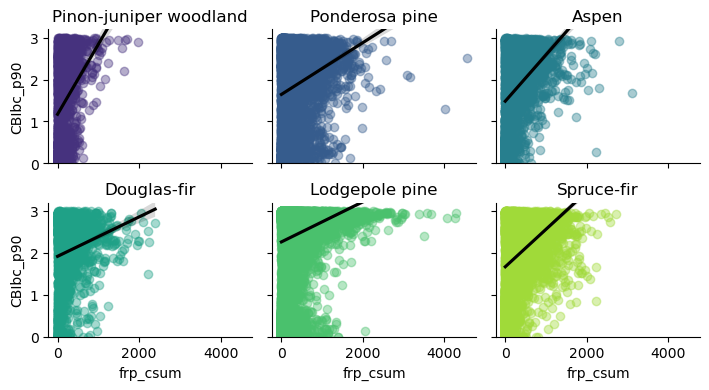

In [67]:
g = sns.lmplot(
    data=tm_sev_d, x='frp_csum', y='CBIbc_p90', hue='SpeciesName', col='SpeciesName', 
    col_wrap=3, height=2, aspect=1.2, scatter_kws={'alpha':0.4}, line_kws={'color':'black'}, 
    sharey=True, palette='viridis'
)

# Adjust the titles to remove the "species_name = " prefix
for ax in g.axes.flat:
    ax.set_ylim(0, tm_sev_d['CBIbc_p90'].max()+0.2)  # Set the y-axis limit from 0 to 4
    ax.set_title(ax.get_title().replace('SpeciesName = ', ''))

plt.savefig(os.path.join(projdir,'figures/FigureX_SpeciesName-FRP-CBIbc.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# correlation_df.to_csv(os.path.join(projdir, 'data/tabular/mod/afds_aspen-fires_frp-cbi_pearson.csv'))